## Kaggle Competition
# iMaterialist Challenge: Furniture
### Data Processing
#### Team: LSDA-21

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns


import json
import csv


from PIL import Image
import h5py


from pathlib import Path
from os import listdir
from os.path import abspath, isfile, join, basename
from time import sleep
import re


from tqdm import tqdm
from natsort import natsorted


%matplotlib inline 

/Users/steven/.local/share/virtualenvs/B4-5100-4F18-LSDA-iftAmOns/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Retrieving the Data from JSON

In [2]:
with open('../../json/train.json') as datafile1:
    data1 = json.load(datafile1)

with open('../../json/test.json') as datafile2:
    data2 = json.load(datafile2)

with open("../../json/validation.json") as datafile3:
    data3 = json.load(datafile3)

#### Converting JSON format data into Tabular data

In [3]:
training   = json.load(open('../../json/train.json'))
test       = json.load(open('../../json/test.json'))
validation = json.load(open('../../json/validation.json'))

In [4]:
def joinFn(dat):
    return [dat[0]["url"][0], dat[0]["image_id"], dat[1]["label_id"]]

train_data      = pd.DataFrame(list(map(joinFn,zip(training["images"],training["annotations"]))),\
                               columns=['url','image_id','label_id'])
test_data       = pd.DataFrame(list(map(lambda x: x["url"],test["images"])),columns=["url"])
validation_data = pd.DataFrame(list(map(joinFn, zip(validation["images"],validation["annotations"]))),\
                               columns=['url','image_id','label_id'])

In [5]:
train_data.head()

,url,image_id,label_id
0,https://img13.360buyimg.com/imgzone/jfs/t2857/...,1,5
1,http://www.tengdakeli.cn/350/timg01/uploaded/i...,2,5
2,https://img13.360buyimg.com/imgzone/jfs/t8899/...,3,5
3,http://img4.tbcdn.cn/tfscom/i1/2855447419/TB2S...,4,5
4,http://a.vpimg4.com/upload/merchandise/287883/...,5,5


#### Remove Rows for which no images are downloaded

In [6]:
def file_list(directory):
    directory = abspath(directory)
    filenames  = [f for f in listdir(directory) if isfile(join(directory, f))]
    files = [Path(directory + '/' + f) for f in natsorted(filenames)]

    return(files)

In [7]:
files_train = file_list('../images/train/')
ids_train = [int(re.match('\d+', basename(f)).group(0))-1 for f in files_train]

files_test = file_list('../images/test/')
ids_test = [int(re.match('\d+', basename(f)).group(0))-1 for f in files_test]

files_val = file_list('../images/validation/')
ids_val = [int(re.match('\d+', basename(f)).group(0))-1 for f in files_val]

In [8]:
train_data.drop(train_data.index[[ids_train]])
test_data.drop(test_data.index[[ids_test]])
validation_data.drop(validation_data.index[[ids_val]]);

####  Read Images as NP arays and save as HDF5 sets

In [9]:
def load_resize_image(infilename, size):
    img = Image.open(infilename)
    img.load()
    img = img.resize((size, size), resample=Image.LANCZOS)
    data = np.asarray(img, dtype="int32" )
    return data


def list_images_labels(X, y, size=256):
    datalen = range(len(X))

    images = [load_resize_image(X[i], size) for i in tqdm(datalen)]
    labels = [y[i] for i in datalen]
    
    return(images,labels)


def save_file(set,X,y,id):
    '''
        set in {"train","test"}
        id = file number
        X = train_images...
        y = train_labels...
    '''
    with h5py.File('{}_{}.h5'.format(set,id), 'w') as hf:
        group = hf.create_group(set)
        group.create_dataset('images', data=X)
        group.create_dataset('labels', data=y)
        

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    # https://stackoverflow.com/a/312464
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [ ]:
img_size = 28
print('Reading Train')
labels_train = train_data['label_id'].tolist()

print('Reading Test')
labels_test = [-1] * len(files_test)

print('Reading Validation')
labels_val = validation_data['label_id'].tolist()


sleep(2)
print('Generating and saving Datasets')
print('Train:')

# train_chunks = list(chunks(range(len(files_train)), round(len(files_train)/10)))
# for i, chunk in enumerate(train_chunks):
#     start = train_chunks[0][0]
#     end = train_chunks[0][-1]
#     im_train = list_images_labels(files_train[start:end], labels_train[start:end], img_size)
#     save_file('train', im_train[0], im_train[1], i)
#     print('{} of {} done...'.format(i+1, len(train_chunks)-1))

im_train = list_images_labels(files_train, labels_train, img_size)
save_file('train', im_train[0], im_train[1], 'train')


print('Test:')
im_test = list_images_labels(files_test, labels_test, img_size)
save_file('test', im_test[0], labels_test, 'test')


print('Validation:')
im_val = list_images_labels(files_val, labels_val, img_size)
save_file('validation', im_val[0], im_val[1], 'val')

#### Check HDF5 sets

##### Combining hdf5 files
If a datasets is split across multiple .hd5 files, they can be accessed via interlinking them.

In [10]:
data_train = h5py.File('../images/img32/train_0.h5','w')
data_train['train1'] = h5py.ExternalLink('train_1.h5', '../images/img32/')
data_train['train2'] = h5py.ExternalLink('train_2.h5', '../images/img32/')
data_train['train3'] = h5py.ExternalLink('train_3.h5', '../images/img32/')
data_train['train4'] = h5py.ExternalLink('train_4.h5', '../images/img32/')
data_train['train5'] = h5py.ExternalLink('train_5.h5', '../images/img32/')
data_train['train6'] = h5py.ExternalLink('train_6.h5', '../images/img32/')
data_train['train7'] = h5py.ExternalLink('train_7.h5', '../images/img32/')
data_train['train8'] = h5py.ExternalLink('train_8.h5', '../images/img32/')
data_train['train9'] = h5py.ExternalLink('train_9.h5', '../images/img32/')
data_train['train10'] = h5py.ExternalLink('train_10.h5', '../images/img32/')
# how to get it all as one?

In [11]:
d_train = h5py.File('../images/img28/train_28.h5', 'r')
d_test = h5py.File('../images/img28/test_28.h5', 'r')
d_val = h5py.File('../images/img28/validation_28.h5', 'r')

In [12]:
Xtrain = d_train['train']['images']
ytrain = d_train['train']['labels']

Xtest = d_test['test']['images']

Xval = d_val['validation']['images']
yval = d_val['validation']['labels']

print(\
'Training samples: {}\n\
Test samples: {}\n\
Validation Samples: {}'.format(Xtrain.shape[0], Xtest.shape[0], Xval.shape[0]))

Training samples: 192171
Test samples: 12704
Validation Samples: 6309


#### Ending with a Image from the Training Set

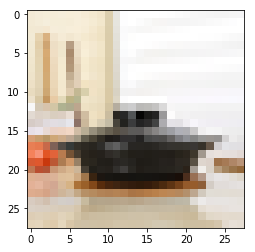

In [13]:
#first image 
i1 = Xtrain[0]
i1_plot = plt.imshow(i1)